   water level                Date
0     0.000000 2024-01-01 00:00:00
1     0.121757 2024-01-01 01:00:00
2     0.243514 2024-01-01 02:00:00
3     0.365271 2024-01-01 03:00:00
4     0.487028 2024-01-01 04:00:00
(2160, 2)


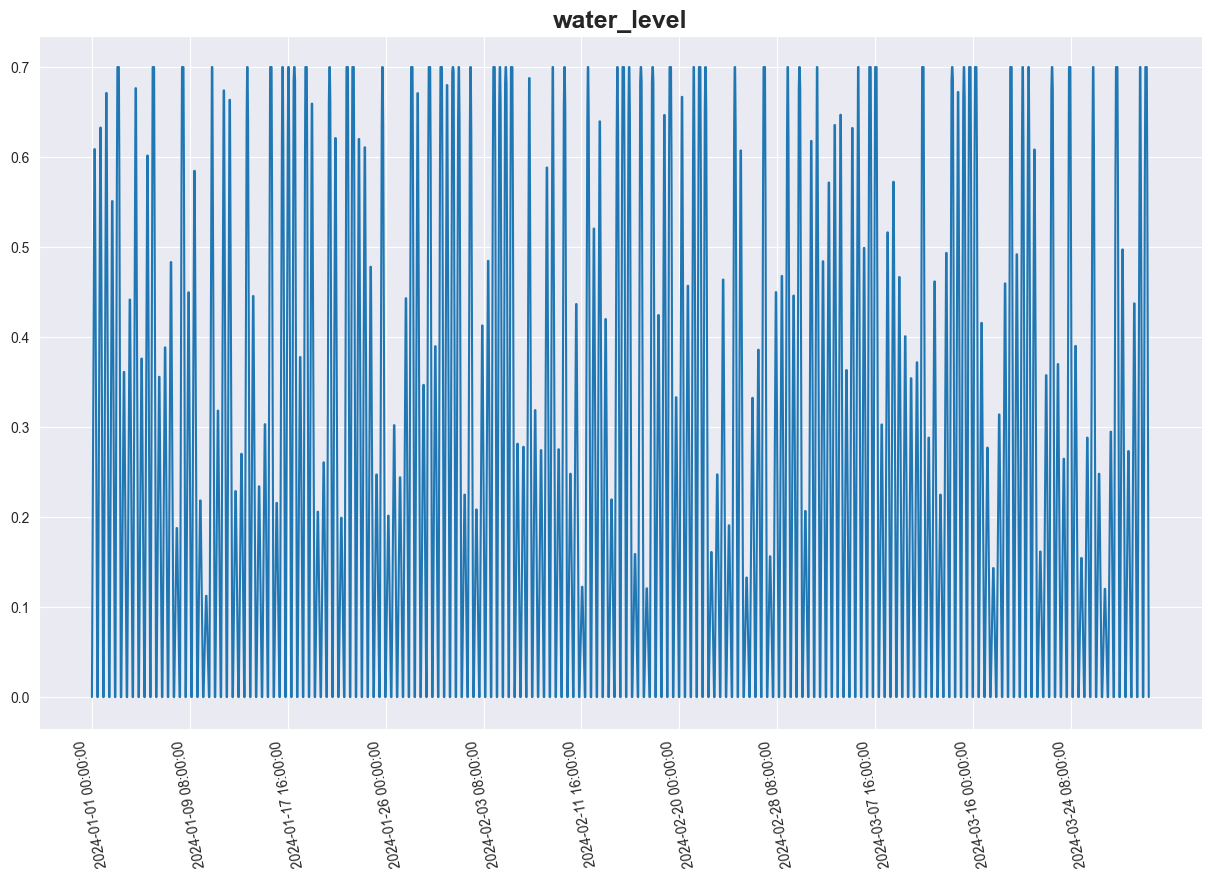

In [307]:
import numpy as np               # 导入NumPy库，用于科学计算
import pandas as pd              # 导入Pandas库，用于数据操作和分析
import matplotlib.pyplot as plt  # 导入Matplotlib库中的pyplot模块，用于绘图
import seaborn as sns            # 导入Seaborn库，用于增强Matplotlib的绘图功能

# 读取数据
filepath = 'simulated_data_k=real_test.csv'
data = pd.read_csv(filepath)  ##从CSV文件读取数据并存储在data变量中。
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M')  ##将Date列转换为datetime格式，便于处理时间序列数据。
print(data.head())  ##打印数据的前几行以查看内容。
print(data.shape)  ##打印数据的形状（行数和列数）。

# 可视化收盘价
sns.set_style("darkgrid")  ##设置Seaborn的绘图风格为“darkgrid”。
plt.figure(figsize=(15, 9))  ##创建一个新的图形，设置大小为15x9英寸。
plt.plot(data[['water level']])  ##绘制water level列的数据。
plt.xticks(range(0, data.shape[0], 200), data['Date'].loc[::200], rotation=100)
##设置x轴的刻度，以每200个数据点显示一个日期，并旋转标签以便于阅读。
plt.title("water_level", fontsize=18, fontweight='bold')  ##设置图表标题。
plt.show()  ##显示图形。

## 1.特征工程

In [308]:
# 选取Close作为特征
price = data[['water level']]              # 从数据集中选取收盘价（Close）列作为特征
print(price.info())                  # 打印选取特征后的数据框信息

from sklearn.preprocessing import MinMaxScaler  # 从sklearn库中导入MinMaxScaler进行数据缩放
# 进行数据缩放，将数据缩放到-1和1之间
scaler = MinMaxScaler(feature_range=(-1, 1))    # 创建MinMaxScaler对象，设置缩放范围为-1到1
price['water level'] = scaler.fit_transform(price['water level'].values.reshape(-1, 1))
                                               # 对收盘价数据进行缩放，并将结果更新到price数据框中
                                               # 先将收盘价数据转换为二维数组，再进行缩放

print(price['water level'].shape)                    # 打印缩放后的数据形状


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   water level  2160 non-null   float64
dtypes: float64(1)
memory usage: 17.0 KB
None
(2160,)


/var/folders/8s/y_3gplhx05z8pjf175k9lqgr0000gn/T/ipykernel_21522/3347666992.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2.数据集制作

In [309]:
# 今天的收盘价预测明天的收盘价
# lookback表示观察的跨度
from sklearn.model_selection import train_test_split
def split_data(stock, lookback):
    data_raw = stock.to_numpy()    # 将数据框转换为NumPy数组
    data = []                      # 初始化存储切分数据的列表

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback]) # 遍历数据，生成长度为lookback的滑动窗口序列并添加到data列表中

    data = np.array(data)  # 将列表转换为NumPy数组
    test_set_size = int(np.round(0.2 * data.shape[0])) # 计算测试集大小，占总数据的20%
    train_set_size = data.shape[0] - (test_set_size) # 计算训练集大小，占总数据的80%

    x_train = data[:train_set_size, :-1, :] # 提取训练集的输入特征（不包括最后一个数据点）
    y_train = data[:train_set_size, -1, :] # 提取训练集的目标值（包括最后一个数据点）
    x_test = data[train_set_size:, :-1] # 提取测试集的输入特征（不包括最后一个数据点）
    y_test = data[train_set_size:, -1, :] # 提取测试集的目标值（包括最后一个数据点）

    return [x_train, y_train, x_test, y_test]  # 返回训练集和测试集的特征和目标值

lookback = 2                      # 定义lookback的跨度为20天
x_train, y_train, x_test, y_test = split_data(price, lookback) # 调用split_data函数进行数据切分
print('x_train.shape = ', x_train.shape)    # 打印训练集特征的形状
print('y_train.shape = ', y_train.shape)    # 打印训练集目标的形状
print('x_test.shape = ', x_test.shape)      # 打印测试集特征的形状
print('y_test.shape = ', y_test.shape)      # 打印测试集目标的形状


x_train.shape =  (1726, 1, 1)
y_train.shape =  (1726, 1)
x_test.shape =  (432, 1, 1)
y_test.shape =  (432, 1)


## 3.模型构建 —— LSTM

In [310]:
import torch                     # 导入PyTorch库
import torch.nn as nn            # 导入PyTorch的神经网络模块

# 将NumPy数组转换为PyTorch张量，并指定数据类型为Tensor
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 32
# 循环的层数
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
# 训练的轮数
num_epochs = 100

# 定义LSTM模型
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim          # 隐藏层特征的维度
        self.num_layers = num_layers          # LSTM的层数

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
                                              # 定义LSTM层，输入维度、隐藏层维度、层数以及batch_first参数
        self.fc = nn.Linear(hidden_dim, output_dim)
                                              # 定义全连接层，将隐藏层输出映射到输出维度

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
                                              # 初始化隐藏状态h0，形状为（层数，批次大小，隐藏层维度）
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
                                              # 初始化细胞状态c0，形状同上

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
                                              # 前向传播，通过LSTM层，输出为out，最后的隐藏状态和细胞状态为hn和cn
        out = self.fc(out[:, -1, :])           # 取LSTM的最后一个时间步的输出并通过全连接层
        return out                            # 返回输出

# 创建LSTM模型实例
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

criterion = torch.nn.MSELoss()               # 定义损失函数为均方误差损失
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
                                              # 定义优化器为Adam，并设置学习率为0.01


## 4.模型训练

In [311]:
import time                         # 导入时间模块，用于计算训练时间

hist = np.zeros(num_epochs)         # 初始化一个数组，用于存储每个epoch的损失值
start_time = time.time()            # 记录训练开始时间
lstm = []                           # 初始化一个列表，用于存储LSTM模型的输出（暂时未使用）

for t in range(num_epochs):         # 开始训练循环，共进行num_epochs次训练
    y_train_pred = model(x_train)   # 前向传播，计算训练集的预测值

    loss = criterion(y_train_pred, y_train_lstm)
                                    # 计算损失函数值，比较预测值与真实值的均方误差
    print("Epoch ", t, "MSE: ", loss.item())
                                    # 打印当前epoch的损失值
    hist[t] = loss.item()           # 将损失值存储到hist数组中

    optimiser.zero_grad()           # 清零梯度，以防止梯度累积
    loss.backward()                 # 反向传播，计算梯度
    optimiser.step()                # 更新模型参数

training_time = time.time() - start_time
                                    # 计算训练所用的总时间
print("Training time: {}".format(training_time))
                                    # 打印训练时间


Epoch  0 MSE:  0.4173886477947235
Epoch  1 MSE:  0.4026637375354767
Epoch  2 MSE:  0.39218375086784363
Epoch  3 MSE:  0.38494205474853516
Epoch  4 MSE:  0.37932834029197693
Epoch  5 MSE:  0.37231066823005676
Epoch  6 MSE:  0.361593633890152
Epoch  7 MSE:  0.34674912691116333
Epoch  8 MSE:  0.3281048536300659
Epoch  9 MSE:  0.3061889111995697
Epoch  10 MSE:  0.2817001938819885
Epoch  11 MSE:  0.25506675243377686
Epoch  12 MSE:  0.225640207529068
Epoch  13 MSE:  0.1927160620689392
Epoch  14 MSE:  0.1579349935054779
Epoch  15 MSE:  0.12637144327163696
Epoch  16 MSE:  0.10371241718530655
Epoch  17 MSE:  0.09096793085336685
Epoch  18 MSE:  0.08905266225337982
Epoch  19 MSE:  0.10153842717409134
Epoch  20 MSE:  0.12250050157308578
Epoch  21 MSE:  0.13166482746601105
Epoch  22 MSE:  0.12744002044200897
Epoch  23 MSE:  0.11675600707530975
Epoch  24 MSE:  0.10409389436244965
Epoch  25 MSE:  0.09250997006893158
Epoch  26 MSE:  0.08509641140699387
Epoch  27 MSE:  0.0829281210899353
Epoch  28 MSE:

## 5.模型结果可视化

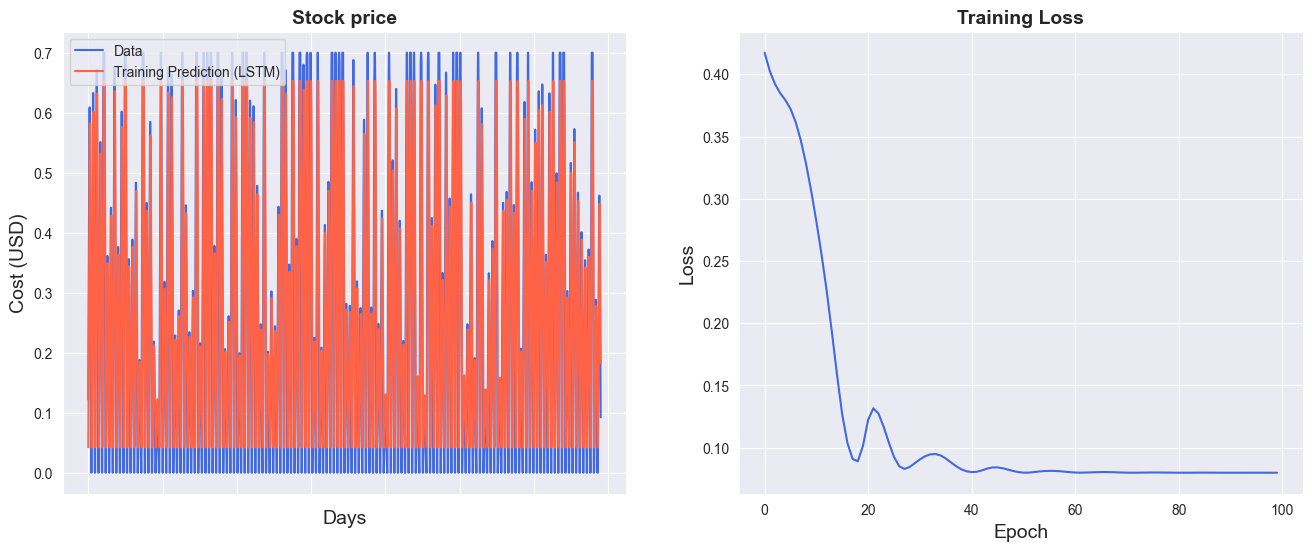

In [312]:
# 将预测值和真实值进行逆缩放，转换回原始的收盘价
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

import seaborn as sns                 # 导入Seaborn库，用于绘图
sns.set_style("darkgrid")             # 设置绘图风格为darkgrid

fig = plt.figure()                    # 创建一个新的图形对象
fig.subplots_adjust(hspace=0.2, wspace=0.2)
                                      # 调整子图之间的间距

plt.subplot(1, 2, 1)                  # 创建第一个子图
ax = sns.lineplot(x=original.index, y=original[0], label="Data", color='royalblue')
                                      # 绘制原始收盘价曲线
ax = sns.lineplot(x=predict.index, y=predict[0], label="Training Prediction (LSTM)", color='tomato')
                                      # 绘制LSTM模型的训练预测曲线

ax.set_title('Stock price', size=14, fontweight='bold')
                                      # 设置第一个子图的标题
ax.set_xlabel("Days", size=14)        # 设置x轴标签
ax.set_ylabel("Cost (USD)", size=14)  # 设置y轴标签
ax.set_xticklabels('', size=10)       # 设置x轴刻度标签大小

plt.subplot(1, 2, 2)                  # 创建第二个子图
ax = sns.lineplot(data=hist, color='royalblue')
                                      # 绘制训练损失值曲线
ax.set_xlabel("Epoch", size=14)       # 设置x轴标签
ax.set_ylabel("Loss", size=14)        # 设置y轴标签
ax.set_title("Training Loss", size=14, fontweight='bold')
                                      # 设置第二个子图的标题
fig.set_figheight(6)                  # 设置图形高度
fig.set_figwidth(16)                  # 设置图形宽度
plt.show()                            # 显示图形


## 6.模型验证

In [313]:
import math, time                       # 导入数学和时间模块
from sklearn.metrics import mean_squared_error, r2_score
                                        # 导入均方误差和R2评分函数

# make predictions
y_test_pred = model(x_test)             # 使用模型对测试集进行预测

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
                                        # 对训练集的预测结果进行逆缩放
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
                                        # 对训练集的真实值进行逆缩放
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
                                        # 对测试集的预测结果进行逆缩放
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())
                                        # 对测试集的真实值进行逆缩放

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
                                        # 计算训练集的均方根误差
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
                                        # 计算测试集的均方根误差
print('Test Score: %.2f RMSE' % (testScore))

trainr2Score = r2_score(y_train[:, 0], y_train_pred[:, 0])
                                        # 计算训练集的R2评分
print('Train Score: %.2f R2' % (trainr2Score))
testr2Score = r2_score(y_test[:, 0], y_test_pred[:, 0])
                                        # 计算测试集的R2评分
print('Test Score: %.2f R2' % (testr2Score))

# 计算 Mean Squared Error (MSE)
trainMSE = mean_squared_error(y_train, y_train_pred)
print('Train Score: %.5f MSE' % (trainMSE))
testMSE = mean_squared_error(y_test, y_test_pred)
print('Test Score: %.5f MSE' % (testMSE))


# 计算 Nash-Sutcliffe Efficiency (NSE)
def nash_sutcliffe_efficiency(observed, predicted):
    return 1 - (np.sum((observed - predicted) ** 2) / np.sum((observed - np.mean(observed)) ** 2))


trainNSE = nash_sutcliffe_efficiency(y_train, y_train_pred)
print('Train Score: %.2f NSE' % (trainNSE))
testNSE = nash_sutcliffe_efficiency(y_test, y_test_pred)
print('Test Score: %.2f NSE' % (testNSE))

lstm.append(trainScore)                 # 将训练集RMSE添加到lstm列表
lstm.append(testScore)                  # 将测试集RMSE添加到lstm列表
lstm.append(training_time)              # 将训练时间添加到lstm列表

# shift train predictions for plotting
trainPredictPlot = np.empty_like(price) # 创建与price形状相同的空数组
trainPredictPlot[:, :] = np.nan         # 将所有值初始化为NaN
trainPredictPlot[lookback:len(y_train_pred) + lookback, :] = y_train_pred
                                        # 将训练集预测值放入对应的位置

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)  # 创建与price形状相同的空数组
testPredictPlot[:, :] = np.nan          # 将所有值初始化为NaN
testPredictPlot[len(y_train_pred) + lookback - 1:len(price) - 1, :] = y_test_pred
                                        # 将测试集预测值放入对应的位置

original = scaler.inverse_transform(price['water level'].values.reshape(-1, 1))
                                        # 对原始的收盘价数据进行逆缩放

# Combine predictions for plotting
predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
                                        # 将训练集和测试集的预测值合并
predictions = np.append(predictions, original, axis=1)
                                        # 将原始的收盘价数据添加到预测值中
result = pd.DataFrame(predictions)      # 将结果转换为DataFrame


Train Score: 0.10 RMSE
Test Score: 0.10 RMSE
Train Score: 0.80 R2
Test Score: 0.81 R2
Train Score: 0.00979 MSE
Test Score: 0.00927 MSE
Train Score: 0.80 NSE
Test Score: 0.81 NSE


## 7. 绘制图像

In [314]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()